In [5]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data
import pandas_datareader as web
import eventstudy as es
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import norm
from numpy import sqrt, abs
from datetime import date, datetime, timedelta
import numpy as np
from statistics import NormalDist
from pyxll import xl_func, plot

In [6]:
tickers2 = pd.read_csv("tickers2.csv").drop(["Headqurter"], axis=1).dropna(axis='rows') # import tickers
sectors = list(tickers2['Sector'].unique()) # returns all the unique industries and removes the last nan valeu

sectors

['Basic Materials',
 'Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Industrials',
 'Real Estate',
 'Technology',
 'Utilities']

In [7]:
sector =sectors[0]


In [8]:

# tic = list(tickers2[tickers2['Sector']==sector]['Ticker']) # returns all the tickers based on an industry
tic = pd.read_csv('tickers3.csv')['Ticker'].to_list()
# tic.extend(['VGOV.L','^FTLC'])
# tic = list(tickers2['Ticker'])
tic

['AAL.L',
 'ALTN.L',
 'APF.L',
 'AXS.L',
 'CAML.L',
 'CRDA.L',
 'ELM.L',
 'ESNT.L',
 'EVR.L',
 'GEMD.L',
 'HOC.L',
 'IOF.L',
 'JAY.L',
 'JMAT.L',
 'MNDI.L',
 'MSLH.L',
 'PDL.L',
 'POG.L',
 'RIO.L',
 'SYNT.L',
 'TET.L',
 'VCT.L',
 'VSVS.L',
 'ZTF.L',
 '7DIG.L',
 'ADT.L',
 'AEO.L',
 'AFRN.L',
 'BBSN.L',
 'BIDS.L',
 'BMY.L',
 'BONH.L',
 'BT-A.L',
 'CAU.L',
 'CCP.L',
 'CCPA.L',
 'CCPC.L',
 'CINE.L',
 'CNIC.L',
 'DBOX.L',
 'DCD.L',
 'EBQ.L',
 'EMAN.L',
 'FDEV.L',
 'FOUR.L',
 'FUTR.L',
 'GAMA.L',
 'IME.L',
 'INF.L',
 'ITV.L',
 'JWNG.L',
 'LVCG.L',
 'MAI.L',
 'MDZ.L',
 'MONY.L',
 'MOS.L',
 'NAH.L',
 'NFC.L',
 'OMIP.L',
 'PSON.L',
 'QRT.L',
 'RCH.L',
 'REL.L',
 'RMV.L',
 'SAA.L',
 'SAL.L',
 'SNWS.L',
 'STVG.L',
 'SYS1.L',
 'TMG.L',
 'ULS.L',
 'VOD.L',
 'WPP.L',
 'YOU.L',
 'ZIN.L',
 'AO.L',
 'ASC.L',
 'BDEV.L',
 'BKG.L',
 'BOO.L',
 'BRBY.L',
 'BWNG.L',
 'BWY.L',
 'CAR.L',
 'CARD.L',
 'COA.L',
 'CPG.L',
 'CRST.L',
 'DNLM.L',
 'DOM.L',
 'DTY.L',
 'FSTA.L',
 'GAW.L',
 'GLE.L',
 'GMR.L',
 'HEAD.L',

In [9]:
le = 14 # days before day 0
ue = 43 # days after day 0
event_date = datetime(2016,6,24) # event date 
start = (event_date - timedelta(days=le)).strftime('%Y-%m-%d')  #start date for event perion plus change of date format
# start = start.strftime('%Y-%m-%d') 
end = (event_date + timedelta(days=ue)).strftime('%Y-%m-%d') #end date for event perion plus change of date format
# end = end.strftime('%Y-%m-%d')
# start date for estimation period
start_date = (event_date - timedelta(days=le+(event_date-datetime(2015,1,1)).days)).strftime('%Y-%m-%d')# 292=200, 146=100, # start date for estimation period
# end date for estimation period
end_date = start





In [10]:
rf = yf.download('VGOV.L', start=start_date, end=end_date, interval='1d')['Adj Close'] # download a 10 year gilt data for estimation period
market = yf.download('^FTLC', start=start_date, end=end_date, interval='1d')['Adj Close'] # download market data for estimation period FTSE 350



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
market

Date
2014-12-17    3466.800049
2014-12-18    3536.699951
2014-12-19    3578.699951
2014-12-22    3596.899902
2014-12-23    3610.399902
                 ...     
2016-06-03    3466.500000
2016-06-06    3499.899902
2016-06-07    3505.500000
2016-06-08    3512.800049
2016-06-09    3478.300049
Name: Adj Close, Length: 372, dtype: float64

In [12]:
rf = pd.DataFrame(rf).pct_change()[1:] # calculate pct_change for rf
market = pd.DataFrame(market).pct_change()[1:] # calculate pct_change for market


In [13]:
rf.columns = ['rf'] # rename rf column
market.columns = ['market'] # rename market column
market

,market
Date,
2014-12-18,0.020163
2014-12-19,0.011875
2014-12-22,0.005086
2014-12-23,0.003753
2014-12-24,0.001606
...,...
2016-06-03,0.003154
2016-06-06,0.009635
2016-06-07,0.001600


In [14]:
returns = yf.download(tic, start_date, end_date, interval = "1d")["Adj Close"] # Download Estimation Period Data 
# market_returns = web.get_data_yahoo("^IXIC", start_date, end_date, interval = 'd').pct_change()[1:]['Close']
# risk_free_returns = web.get_data_yahoo('^TNX', start_date, end_date, interval = 'd').pct_change()[1:]['Close']
# returns = pd.DataFrame(returns).pct_change()[1:]
# returns = returns.drop("AAF.L", axis=1).pct_change()[1:]
# returns = returns.pct_change()[1:]
rows = returns.shape[0] # number of rows
returns.index = pd.to_datetime(returns.index, format = '%d/%m/%Y').strftime('%Y-%m-%d') # change row date format
returns


[*********************100%***********************]  586 of 586 completed


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,...,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-17,13.2,2669.330811,40.043514,128.501648,16.875,883.099670,422.741547,40.0,601.671021,167.5,...,3441.202393,273.480072,17.750,979.427368,121.721825,1925.0,6.25,175.0,204.624802,210.499512
2014-12-18,13.2,2669.330811,42.979626,128.840714,16.500,890.732056,430.273682,40.0,601.671021,167.5,...,3558.088135,307.693604,17.250,970.187622,121.721825,1925.0,6.25,185.0,204.624802,215.687866
2014-12-19,13.2,2669.330811,42.083649,129.094879,16.500,910.577332,430.979858,40.0,601.671021,167.5,...,3602.688965,312.711578,17.250,960.947571,119.804947,1875.0,6.25,167.5,204.624802,215.687866
2014-12-22,13.2,2669.330811,42.480461,129.518890,16.500,895.693420,433.098236,40.0,599.194885,167.5,...,3640.368896,318.413818,19.250,960.947571,119.804947,1875.0,6.50,200.0,206.435638,219.393860
2014-12-23,13.2,2669.330811,43.770100,130.112122,16.500,901.799622,431.450592,40.0,597.709290,167.5,...,3671.128906,323.203735,19.000,958.637695,119.804947,1825.0,6.50,240.0,209.151886,223.470459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-03,4.8,80.673126,45.274200,153.445465,6.625,501.466949,630.453308,40.0,1297.430420,282.5,...,3319.040039,444.491394,9.375,1140.244995,177.038406,487.5,9.25,17.0,276.673004,273.915192
2016-06-06,4.8,80.673126,45.134842,152.721466,6.625,557.221497,634.771606,40.0,1287.526367,282.5,...,3289.675049,444.726807,9.250,1124.317261,173.661621,475.0,9.25,17.5,282.281189,281.763763
2016-06-07,4.8,80.673126,46.498528,151.182007,6.625,540.097412,634.291748,40.0,1287.526367,282.5,...,3315.865479,446.374847,9.000,1156.172974,172.214462,475.0,9.25,17.0,280.411835,281.763763


In [15]:
# rf = pd.read_csv("10y.csv")
# rf.index = list(rf['Date'])
# rf


In [16]:
pd.set_option("display.max_rows", 20) # change max display of rows
pd.set_option("display.max_columns", None) # change max display of columns

In [17]:
isn = dict(returns.isnull().mean().transpose()) # check how many null values are there column wise 
for sym, val in isn.items():
    if returns.shape[0]==rows and val>0: # loop to check whether dates are the same number and if there are null values in the dataset
        returns.drop([sym],axis=1,inplace=True) # if found drops corresponding ticker
    
    # print(sym, val)
returns

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [18]:
returns = returns.pct_change()[1:] # returns of the dataset
returns


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [19]:
for i in range(len(returns.columns[:])): # loop to get excess returns r(it)-E[rf]
    returns[returns.columns[i]] = returns[returns.columns[i]] - rf['rf'].mean()
returns.dropna()

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [20]:
returns = returns.dropna() # drops na values
x = market['market'] # independent variable for regression
x_sm = sm.add_constant(x) # add constant
values = pd.DataFrame(index=['0','1'], columns=list(returns.columns)[:]) # create dataframe to store alpha and beta 

In [21]:

for i in range(len(returns.columns[:])): # run regression and store alpha and beta in values dataframe 0=alpha, 1=beta
    returns = returns.dropna()
    y = list(returns[returns.columns[i]])
    model = sm.OLS(y,x_sm)
    results = model.fit()
    values.iat[0,i] = results.params[0]
    values.iat[1,i] = results.params[1]
  

In [22]:
values

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
0,-0.002565,4.00014,0.000516,0.000446,-0.001901,-0.000546,0.000979,-0.000159,0.001981,0.001306,0.001216,0.000717,0.001953,-0.00015,-0.00058,0.002591,-0.000131,0.000159,0.000448,-0.000243,0.000101,-0.000324,0.001642,-0.000235,-0.000697,-0.000041,0.00127,0.001138,-0.001124,0.00

In [23]:
ls = list(returns.columns) # return a list of columns from returns dataframe (tickers)
ls.append('^FTLC')
event = yf.download(ls,start, end, interval='1d').pct_change()[1:]['Adj Close'] # download event data for tickers and market 
event.index = pd.to_datetime(event.index, format = '%d/%m/%Y').strftime('%Y-%m-%d')
# if event.shape[0]%2==0:
ix = np.arange(-int(event.index.get_loc('2016-06-24')),int(int(event.shape[0] - event.index.get_loc('2016-06-24')))) # change dates to a day timeframe counting down to 0(event day) and up after the event
event.index = ix # change event dataframe index to countdown

event



[*********************100%***********************]  587 of 587 completed


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.0,0.000000,-0.023612,0.001139,0.000000,-0.035285,-0.012289,0.0,0.017578,0.000000,-0.033976,-0.026316,0.000000,0.0,-0.002488,-0.047619,-0.030172,-0.007576,-0.009573,-0.003171,0.000000,-0.021418,0.020377,-0.013889,0.000000,0.012500,-0.007663,0.000000,-0.013150,-0.03

In [24]:
event.isna().values.any()
event


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.0,0.000000,-0.023612,0.001139,0.000000,-0.035285,-0.012289,0.0,0.017578,0.000000,-0.033976,-0.026316,0.000000,0.0,-0.002488,-0.047619,-0.030172,-0.007576,-0.009573,-0.003171,0.000000,-0.021418,0.020377,-0.013889,0.000000,0.012500,-0.007663,0.000000,-0.013150,-0.03

In [25]:
ar_returns = pd.DataFrame(index = ix, columns =list(event.columns)) # create abnormal returns dataframe
for i in range(len(event.columns[:-1])):
    returns = returns.dropna()
    ar_returns[event.columns[i]] = event[event.columns[i]] - (values.iat[0,i] + values.iat[1,i]*event['^FTLC']) #calculates abnormal returns (stock returns - normal returns )

In [26]:
ar_returns
# plt.plot(ar_returns.index, ar_returns)

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.002522,5.692171,-0.002580,0.003852,0.007477,0.007892,-0.001735,0.000159,0.016360,-0.001851,-0.021303,-0.015924,0.003749,0.004431,0.004209,-0.040748,-0.028411,-0.002037,-0.005597,0.009160,0.003472,0.000691,0.028961,0.000565,0.002281,0.009036,0.000332,0.003084,-0.00

In [27]:
ar_returns.std(axis=0)
asd = ar_returns/ar_returns.std(axis=0)
asd

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,73.648683,0.731183,-0.105369,0.389257,0.152733,0.303326,-0.114735,inf,0.788506,-0.371704,-1.465810,-0.385931,0.254908,0.292208,0.214867,-0.664785,-1.620337,-0.081807,-0.219496,1.082397,0.127327,0.040735,1.197594,0.026441,0.065584,0.291366,0.029662,0.244829,-0.157432

In [28]:
ar_returns.describe()

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,

In [29]:
ar_returns.drop(['^FTLC'], axis=1, inplace=True) # removes market data column
aar = ar_returns.mean(axis=1) # calculates the average of the rows
aar = pd.DataFrame(aar,columns = ['AAR']) #creates dataframe of aar
aar

,AAR
-10,0.009350
-9,-0.002845
-8,0.002689
-7,-0.014606
-6,-0.012780
...,...
26,0.000715
27,-0.001130
28,-0.004319
29,-0.020878


In [30]:
plt.close("all")


In [31]:
car = pd.DataFrame(index = ix, columns =list(event.columns[:-1])) # create car dataframe
car

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [32]:
for i in range(len(event.columns[:-1])):
    returns = returns.dropna()
    car[event.columns[i]] = ar_returns[returns.columns[i]].cumsum() # calculates car values 

In [33]:
i = (ar_returns.var(axis=0)/(20**2)).sum()
i

0.15305773792903649

In [34]:
caar = pd.DataFrame(car.mean(axis=1), columns=['CAAR']) # creates caar dataframe and calculates caar
caar

,CAAR
-10,0.009350
-9,0.006505
-8,0.009194
-7,-0.005411
-6,-0.018192
...,...
26,-0.341396
27,-0.342526
28,-0.346845
29,-0.367723


In [35]:
# caar['Variance'] = car.var(axis=1)
# caar['t-stat'] = (caar['CAAR']/(caar['Variance']**(1/2)))*(float(car.shape[1])**(1/2))
caar['Variance'] = ""
for i in range(len(ar_returns.index)): # calculates variance of caar
    caar.iat[i,1]=((ar_returns.var(axis=0).sum())/(ar_returns.shape[1]**2))*(caar.index[i]-caar.index[0]+1) 
caar = caar.astype(float) # changes values to float 
   
caar['t-stat'] = (caar['CAAR']/(caar['Variance']**(1/2))) # calculates t-stat for caar
caar['p-value'] = norm.cdf(caar['t-stat']) # calculates p-value for caar
# caar['p-value'] = ss.t.sf(abs(caar['t-stat']),float(caar.shape[1]-2))
caar['Significance'] = ""
for i in range(len(caar.index)): # adds asterics for signifficance
    if caar.iat[i,3]<=0.001:
        caar.iat[i,4]="***"
    elif 0.001<caar.iat[i,3]<=0.01:
        caar.iat[i,4]="**"
    elif 0.01<caar.iat[i,3]<=0.05:
        caar.iat[i,4]="*"
    else:
        caar.iat[i,4]=""
caar['95% CI'] = ""
for i in range(len(ar_returns.index)): # calculates 95% Confidence Interval
    caar.iat[i,5] = NormalDist(mu=0, sigma=sqrt(caar.iat[i,1])).inv_cdf(0.05)
caar['99% CI'] = ""
for i in range(len(ar_returns.index)): # Calculates 99% Confidence Interval
    caar.iat[i,6] = NormalDist(mu=0, sigma=sqrt(caar.iat[i,1])).inv_cdf(0.01)

In [36]:

# caar.iat[1,1]=(ar_returns.var(axis=0).sum())/((ar_returns.shape[1]**2)*(caar.index[1]-caar.index[0]+1))
caar[7:14]


,CAAR,Variance,t-stat,p-value,Significance,95% CI,99% CI
-3,-0.075915,0.001426,-2.010123,0.022209,*,-0.06212,-0.087858
-2,-0.086460,0.001605,-2.158400,0.015448,*,-0.065888,-0.093187
-1,-0.102164,0.001783,-2.419576,0.007769,**,-0.069452,-0.098228
0,-0.107738,0.001961,-2.432846,0.007490,**,-0.072842,-0.103022
1,-0.120670,0.002139,-2.608846,0.004542,**,-0.076081,-0.107603
2,-0.147286,0.002318,-3.059346,0.001109,**,-0.079188,-0.111997
3,-0.181416,0.002496,-3.631213,0.000141,***,-0.082177,-0.116225


In [37]:
aar['Variance'] = ar_returns.var(axis=1) # calculates variance of aar 
aar['t-stat'] = (aar['AAR']/(aar['Variance']**(1/2)))*(float(car.shape[1])**(1/2)) # calculates t-stat for aar
# aar['p-value'] = ss.t.sf(abs(aar['t-stat']),float(car.shape[1]-2))
aar['p-value'] = norm.cdf(aar['t-stat']) # calculates p-value for aar
aar['Significance'] = ""
for i in range(len(aar.index)): # adds asterics for signifficance
    if aar.iat[i,3]<=0.001:
        aar.iat[i,4]="***"
    elif 0.001<aar.iat[i,3]<=0.01:
        aar.iat[i,4]="**"
    elif 0.01<aar.iat[i,3]<=0.05:
        aar.iat[i,4]="*"
    else:
        aar.iat[i,4]=""

In [38]:
aar

,AAR,Variance,t-stat,p-value,Significance
-10,0.009350,0.055893,0.957373,8.308106e-01,
-9,-0.002845,0.011095,-0.653819,2.566141e-01,
-8,0.002689,0.077510,0.233834,5.924432e-01,
-7,-0.014606,0.098932,-1.124094,1.304866e-01,
-6,-0.012780,0.003548,-5.194055,1.028811e-07,***
...,...,...,...,...,...
26,0.000715,0.004564,0.256206,6.011041e-01,
27,-0.001130,0.000764,-0.990236,1.610295e-01,
28,-0.004319,0.015167,-0.848869,1.979770e-01,
29,-0.020878,0.260429,-0.990343,1.610034e-01,


In [39]:
pd.set_option("display.max_columns", None)

In [40]:
# pd.set_option("display.max_rows", 15)

In [41]:
data = pd.concat([aar,caar], axis=1) # combines aar and caar together
data.transpose()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
AAR,0.00935,-0.002845,0.002689,-0.014606,-0.01278,-0.01366,-0.031528,-0.012536,-0.010545,-0.015705,-0.005574,-0.012931,-0.026616,-0.03413,-0.02404,-0.013371,-0.000892,-0.020565,-0.004112,-0.013073,-0.011572,-0.009476,-0.001214,-0.001744,-0.000753,-0.006517,-0.009077,-0.00633,-0.007561,0.001867,-0.012983,-0.000764,-0.007169,-0.005218,-0.001132,-0.004999,0.000715,-0.00113,-0.004319,-0.020878,-0.009927
Variance,0.055893,0.011095,0.07751,0.098932,0.003548,0.223444,0.705666,0.056095,0.07957,0.205424,0.465419,0.313289,0.605782,0.877086,0.412192,0.173568,0.004924,0.022937,0.008246,0.173851,0.150351,0.288808,0.036708,0.016564,0.017818,0.038114,0.071745,0.032609,0.076573,0.00922,0.056095,0.017932,0.04021,0.078132,0.007964,0.033585,0.004564,0.000764,0.015167,0.260429,0.127666
t-stat,0.957373,-0.653819,0.233834,-1.124094,-5.194055,-0.699538,-0.908535,-1.281273,-0.904908,-0.838788,-0.197792,-0.559273,-0.827805,-0.882207,-0.90643,-0.776935,-0.30781,-3.287176,-1.096155,-0.758994,-0.722419,-0.426825,-0.153368,-0.328084,-0.136605,-0.808054,-0.820315,-0.848514,-0.661465,0.47071,-1.326979,-0.13812,-0.865476,-0.451887,-0.307013,-0.660329,0.256206,-0.990236,-0.848869,-0.990343,-0.672571
p-value,0.830811,0.256614,0.592443,0.130487,0.0,0.242108,0.181798,0.100049,0.182757,0.200794,0.421604,0.287988,0.203891,0.188833,0.182354,0.218599,0.379114,0.000506,0.136505,0.223928,0.235019,0.334753,0.439054,0.371424,0.445672,0.20953,0.206018,0.198076,0.254157,0.681076,0.092258,0.445073,0.193389,0.325675,0.379417,0.254521,0.601104,0.16103,0.197977,0.161003,0.25061
Significance,,,,,***,,,,,,,,,,,,,***,,,,,,,,,,,,,,,,,,,,,,,
CAAR,0.00935,0.006505,0.009194,-0.005411,-0.018192,-0.031851,-0.063379,-0.075915,-0.08646,-0.102164,-0.107738,-0.12067,-0.147286,-0.181416,-0.205456,-0.218827,-0.21972,-0.240285,-0.244397,-0.25747,-0.269042,-0.278517,-0.279731,-0.281475,-0.282229,-0.288745,-0.297822,-0.304152,-0.311713,-0.309846,-0.322829,-0.323593,-0.330762,-0.33598,-0.337112,-0.342111,-0.341396,-0.342526,-0.346845,-0.367723,-0.37765
Variance,0.000178,0.000357,0.000535,0.000713,0.000891,0.00107,0.001248,0.001426,0.001605,0.001783,0.001961,0.002139,0.002318,0.002496,0.002674,0.002853,0.003031,0.003209,0.003387,0.003566,0.003744,0.003922,0.004101,0.004279,0.004457,0.004635,0.004814,0.004992,0.00517,0.005349,0.005527,0.005705,0.005883,0.006062,0.00624,0.006418,0.006597,0.006775,0.006953,0.007131,0.00731
t-stat,0.700245,0.344489,0.397558,-0.202635,-0.609291,-0.973853,-1.794061,-2.010123,-2.1584,-2.419576,-2.432846,-2.608846,-3.059346,-3.631213,-3.972953,-4.097147,-3.991023,-4.241606,-4.199127,-4.311732,-4.396933,-4.447139,-4.368344,-4.303034,-4.227378,-4.241002,-4.292547,-4.304784,-4.335069,-4.236675,-4.342419,-4.284145,-4.312201,-4.315332,-4.267565,-4.270274,-4.203369,-4.161426,-4.159519,-4.35442,-4.417101
p-value,0.758113,0.634761,0.654522,0.41971,0.271166,0.165065,0.036402,0.022209,0.015448,0.007769,0.00749,0.004542,0.001109,0.000141,0.000035,0.000021,0.000033,0.000011,0.000013,0.000008,0.000005,0.000004,0.000006,0.000008,0.000012,0.000011,0.000009,0.000008,0.000007,0.000011,0.000007,0.000009,0.000008,0.000008,0.00001,0.00001,0.000013,0.000016,0.000016,0.000007,0.000005
Significance,,,,,,,*,*,*,**,**,**,**,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***


In [42]:
# data.to_latex('main.tex')

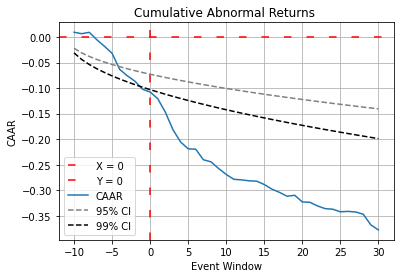

In [54]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,caar['CAAR'],linewidth=1.5, label='CAAR')#plots caar values 
ax.plot(caar.index.values,caar['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,caar['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("CAAR") # label y axis
ax.set_title(f'Cumulative Abnormal Returns {sectors[5]} Sector') # label table
ax.grid() # add grid to table
plt.show()
fig.savefig(fname=f'Cumulative Abnormal Returns {sector} Sector.png')

Nonparametric data

In [46]:
returnsNP = yf.download(ls, start, end, interval = "1d")["Adj Close"] # Download Estimation Period Data 
rows = returnsNP.shape[0] # number of rows
returnsNP.index = pd.to_datetime(returnsNP.index, format = '%d/%m/%Y').strftime('%Y-%m-%d') # change row date format

isn = dict(returnsNP.isnull().mean().transpose()) # check how many null values are there column wise 
for sym, val in isn.items():
    if returnsNP.shape[0]==rows and val>0: # loop to check whether dates are the same number and if there are null values in the dataset
        returnsNP.drop([sym],axis=1,inplace=True) # if found drops corresponding ticker
    
    
returnsNP = returnsNP.pct_change()[1:]
returnsNP.index = np.arange(-returnsNP.shape[0]+(returnsNP.shape[0]-1-returnsNP.index.get_loc('2016-06-24')+1),returnsNP.shape[0]-1-returnsNP.index.get_loc('2016-06-24')+1,dtype=object)

ar_returns = pd.DataFrame(index = list(returnsNP.index), columns =list(returnsNP.columns)) # create abnormal returns dataframe
for i in range(len(ar_returns.columns[:-1])):
    returnsNP = returnsNP.dropna()
    ar_returns[ar_returns.columns[i]] = returnsNP[ar_returns.columns[i]] - (values.iat[0,i] + values.iat[1,i]*returnsNP['^FTLC']) #calculates abnormal returns (stock returns - normal returns )

ar_returns.drop(['^FTLC'], axis=1, inplace=True) # removes market data column

ar_returns_sign = pd.DataFrame(index = list(ar_returns.index), columns =['t-sign', 'p-value', '95% CI','99% CI'])

ar_returns = ar_returns.transpose()

[*********************100%***********************]  587 of 587 completedd

1 Failed download:
- TRAK.L: No data found for this date range, symbol may be delisted


In [47]:
# ar_returns_sign[['t-sign', 'p-value', '95% CI','99% CI']] = None

In [48]:
ar_returns_sign = ar_returns_sign.transpose()
for i in range(len(ar_returns_sign.columns)):
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('t-sign'),i] = ((len(ar_returns[ar_returns[ar_returns.columns[i]]>0.0])/(ar_returns.shape[0]))-0.5)*(sqrt(ar_returns.shape[0])/0.5)
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('p-value'),i] = norm.cdf(ar_returns_sign.iat[0,i])
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('95% CI'),i] = NormalDist(mu=0, sigma=1).inv_cdf(0.05)
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('99% CI'),i] =NormalDist(mu=0, sigma=1).inv_cdf(0.01)

    
        
ar_returns_sign = ar_returns_sign.transpose()
ar_returns_sign = ar_returns_sign.astype(float)
# ar_returns_sign['p-value'] = norm.cdf(ar_returns_sign['t-stat'])
# ar_returns_sign = ar_returns_sign[ar_returns_sign.index.get_loc(-30):]
ar_returns_sign[7:14]


,t-sign,p-value,95% CI,99% CI
-3,-3.597007,1.609497e-04,-1.644854,-2.326348
-2,-1.281692,9.997531e-02,-1.644854,-2.326348
-1,0.289414,6.138679e-01,-1.644854,-2.326348
0,-11.369851,2.954430e-30,-1.644854,-2.326348
1,-10.129503,2.043601e-24,-1.644854,-2.326348
2,2.604729,9.954027e-01,-1.644854,-2.326348
3,1.612452,9.465681e-01,-1.644854,-2.326348


In [49]:
len(ar_returns[ar_returns[ar_returns.columns[4]]>0.0])
ar_returns.shape[0]

585

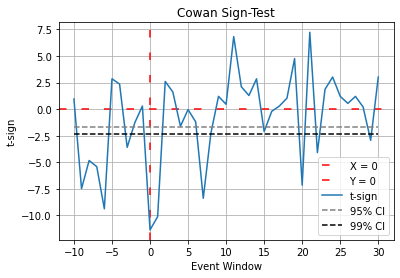

In [50]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,ar_returns_sign['t-sign'],linewidth=1.5, label='t-sign')#plots caar values 
ax.plot(caar.index.values,ar_returns_sign['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,ar_returns_sign['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("t-sign") # label y axis
ax.set_title('Cowan Sign-Test') # label table
ax.grid() # add grid to table
plt.show()
fig.savefig(fname=f'Cowan Sign-Test {sector} Sector.png')

In [51]:
rank = ar_returns.rank(axis=1)
rank
ar_returns_rank = pd.DataFrame(columns = rank.columns.tolist(), index= ['rank', 's(rank)', 't-rank', 'p-value','95% CI','99% CI'])
ar_returns_rank
for i in range(ar_returns_rank.shape[1]):
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('rank'),i] = (rank[rank.columns[i]].sum()-(rank.shape[0]*(rank.shape[1]+1)/2))/(rank.shape[0])
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('s(rank)'),i] = sqrt((ar_returns_rank.pow(2, axis=1).sum(axis=1)[0])/(rank.shape[0]))
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('t-rank'),i] = ar_returns_rank.iat[0,i]/ar_returns_rank.iat[1,i]
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('p-value'),i] = norm.cdf(ar_returns_rank.iat[2,i])
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('95% CI'),i] = NormalDist(mu=0, sigma=1).inv_cdf(0.05)
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('99% CI'),i] =NormalDist(mu=0, sigma=1).inv_cdf(0.01)

In [52]:
ar_returns_rank = ar_returns_rank.transpose()



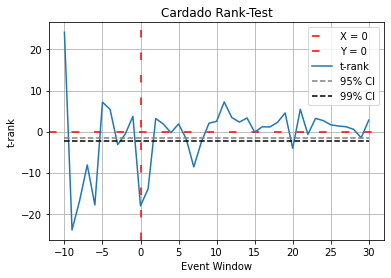

In [53]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,ar_returns_rank['t-rank'],linewidth=1.5, label='t-rank')#plots caar values 
ax.plot(caar.index.values,ar_returns_rank['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,ar_returns_rank['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("t-rank") # label y axis
ax.set_title('Cardado Rank-Test') # label table
ax.grid() # add grid to table
plt.show()
fig.savefig(fname=f'Corrado Rank-Test {sector} Sector.png')


Nonparametric data

In [ ]:
combined_data = pd.DataFrame()


In [ ]:
combined_data = pd.concat([combined_data,caar])
combined_data

,CAAR,Variance,t-stat,p-value,Significance,95% CI,99% CI
-10,0.009422,0.000178,0.705671,0.759804,,-0.021963,-0.031062
-9,0.006650,0.000357,0.352188,0.637651,,-0.03106,-0.043929
-8,0.009412,0.000535,0.406970,0.657985,,-0.038041,-0.053802
-7,-0.005119,0.000713,-0.191696,0.423990,,-0.043926,-0.062125
-6,-0.017826,0.000891,-0.597045,0.275239,,-0.04911,-0.069458
...,...,...,...,...,...,...,...
26,-0.338649,0.006597,-4.169543,0.000015,***,-0.133594,-0.188945
27,-0.339706,0.006775,-4.127156,0.000018,***,-0.135388,-0.191481
28,-0.343950,0.006953,-4.124807,0.000019,***,-0.137158,-0.193984
29,-0.364753,0.007131,-4.319255,0.000008,***,-0.138905,-0.196456


In [ ]:
event.transpose()[:-1].describe().iloc[:,6:15].transpose()


,count,mean,std,min,25%,50%,75%,max
-4,586.0,0.017095,0.039629,-0.663337,0.000000,0.015320,0.035919,0.127406
-3,586.0,-0.001137,0.025929,-0.175313,-0.006108,0.000000,0.006364,0.153846
-2,586.0,0.003602,0.033378,-0.096386,-0.002289,0.000000,0.009931,0.666667
-1,586.0,0.009086,0.020739,-0.150000,0.000000,0.006116,0.019157,0.107595
0,586.0,-0.050533,0.057750,-0.448275,-0.073198,-0.040576,-0.014184,0.173913
1,586.0,-0.050321,0.055593,-0.331055,-0.080930,-0.038895,0.000000,0.095238
2,586.0,0.018205,0.034007,-0.151515,0.000000,0.014615,0.035058,0.166677
3,586.0,0.020453,0.035001,-0.294118,0.000000,0.017228,0.039320,0.213483
4,586.0,0.012374,0.033815,-0.192308,0.000000,0.006404,0.025385,0.333333


In [ ]:
ar_returns.describe().iloc[:,6:15].transpose()

,count,mean,std,min,25%,50%,75%,max
-4,586.0,-0.031451,0.840039,-20.312232,-0.006845,0.001481,0.016578,0.111140
-3,586.0,-0.012462,0.236843,-5.700521,-0.007978,-0.000867,0.004225,0.155672
-2,586.0,-0.010470,0.282082,-6.779313,-0.005406,-0.000205,0.006410,0.667639
-1,586.0,-0.015630,0.453238,-10.957543,-0.004629,0.000258,0.010742,0.105192
0,586.0,-0.005503,0.682216,-0.447572,-0.058699,-0.027619,0.000312,16.421994
1,586.0,-0.012860,0.559722,-0.316811,-0.063971,-0.024895,0.001391,13.450725
2,586.0,-0.026540,0.778320,-18.819741,-0.009342,0.002580,0.019234,0.145809
3,586.0,-0.034054,0.936528,-22.652258,-0.009048,0.001842,0.018796,0.192758
4,586.0,-0.023957,0.642022,-15.517157,-0.010075,-0.000602,0.014033,0.324423


In [ ]:
len(event.columns[:-1])
caar[6:15].style

,CAAR,Variance,t-stat,p-value,Significance,95% CI,99% CI
-4,-0.062862,0.001248,-1.779426,0.037585,*,-0.058108,-0.082183
-3,-0.075324,0.001426,-1.994468,0.023050,*,-0.062120,-0.087858
-2,-0.085794,0.001605,-2.141786,0.016105,*,-0.065888,-0.093187
-1,-0.101424,0.001783,-2.402038,0.008152,**,-0.069452,-0.098228
0,-0.106927,0.001961,-2.414525,0.007878,**,-0.072842,-0.103022
1,-0.119787,0.002139,-2.589765,0.004802,**,-0.076081,-0.107603
2,-0.146327,0.002318,-3.039431,0.001185,**,-0.079188,-0.111997
3,-0.180381,0.002496,-3.610487,0.000153,***,-0.082177,-0.116225
4,-0.204337,0.002674,-3.951320,0.000039,***,-0.085061,-0.120304


In [ ]:
# t = pd.DataFrame(event.columns[:-1], columns= ['tickers'])
# t['sector'] = sector
# t.to_csv('asd1.csv' , mode='a', header=False, index=False)

In [ ]:
returns.to_csv('returns_all_370day.csv')

In [ ]:
pd.read_csv('returns_all_370day.csv', index_col=0, )

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [ ]:
event.transpose().describe().transpose()[6:15].to_csv('descriptive_stats.csv', mode='a')

In [ ]:
ar_returns.describe()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,0.009422,-0.002772,0.002762,-0.014531,-0.012707,-0.013585,-0.031451,-0.012462,-0.010470,-0.015630,-0.005503,-0.012860,-0.026540,-0.034054,-0.023957,-0.013296,-0.000819,-0.020492,-0.004039,-0.012998,-0.011497,-0.009400,-0.001140,-0.001671,-0.000679,-0.006443,-0.009002,-0.006256,-0.007487,0.001941,-0.012909,-0.000690,-0.007095,-0.005144,-0.001058,-0.004925,0.000789,-0.001057,-0.004245,-0.020802,-0.009853
std,0.236417,0.105332,0.278406,0.314534,0.059563,0.472699,0.840039,0.236843,0.282082,0.453238,0.682216,0.559722,0.778320,0.936528,0.642022,0.416615,0.070168,0.151448,0.090810,0.416955,0.387751,0.537408,0.191593,0.128701,0.133486,0.195228,0.267853,0.180580,0.276718,0.096021,0.236844,0.133909,0.200525,0.279521,0.089239,0.183263,0.067558,0.027632,0.123156,0.510323,0.357303
min,-0.164008,-0.217131,-0.161006,-7.592685,-1.307813,-11.413585,-20.312232,-5.700521,-6.779313,-10.957543,-0.447572,-0.316811,-18.819741,-22.652258,-15.517157,-10.051452,-0.154229,-3.585105,-0.544645,-10.059755,-9.353615,-12.970452,-4.586891,-3.033469,-3.118401,-4.680530,-6.458062,-4.331055,-6.660936,-2.225486,-5.708810,-3.198549,-4.802796,-6.733896,-2.025595,-4.371710,-1.271908,-0.396352,-2.930362,-12.336451,-8.620552
25%,-0.008089,-0.014047,-0.017701,-0.007590,-0.020457,-0.004833,-0.006845,-0.007978,-0.005406,-0.004629,-0.058699,-0.063971,-0.009342,-0.009048,-0.010075,-0.006738,-0.015215,-0.031885,-0.016822,-0.005397,-0.004188,-0.003115,-0.004659,-0.006617,-0.004517,-0.006938,-0.005501,-0.006085,-0.004971,-0.003358,-0.012582,-0.001496,-0.008306,-0.003357,-0.005238,-0.006915,-0.007770,-0.006281,-0.006766,-0.009425,-0.003136
50%,0.000329,-0.003519,-0.002755,-0.001186,-0.005808,0.002651,0.001481,-0.000867,-0.000205,0.000258,-0.027619,-0.024895,0.002580,0.001842,-0.000602,0.000144,-0.000574,-0.008084,-0.001165,0.000375,0.000271,0.006759,0.000641,0.000542,0.000579,-0.000314,0.000131,0.000169,0.000423,0.001162,-0.001905,0.002295,-0.000837,0.000837,0.000796,0.000279,0.000226,0.000399,0.000112,-0.000970,0.001669
75%,0.005977,0.001911,0.004234,0.003422,0.000868,0.018060,0.016578,0.004225,0.006410,0.010742,0.000312,0.001391,0.019234,0.018796,0.014033,0.012933,0.006340,0.001802,0.005664,0.013012,0.012409,0.025502,0.014445,0.007606,0.009172,0.004575,0.008748,0.006617,0.008546,0.010749,0.001932,0.013193,0.004900,0.014005,0.009290,0.008224,0.006787,0.006828,0.005754,0.006824,0.011607
max,5.692245,2.457604,6.701691,0.211499,0.137511,0.130472,0.111140,0.155672,0.667639,0.105192,16.421994,13.450725,0.145809,0.192758,0.324423,0.351758,1.557728,0.145791,1.932493,0.426813,0.406974,0.339066,0.149208,0.303737,0.447177,0.230841,0.181684,0.180621,0.236782,0.182724,0.267755,0.105835,0.375043,0.271742,0.214638,0.238500,0.777985,0.130306,0.111076,0.203261,0.271236
